<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/tuning_calc/vggface_4class_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preload

Mount the google drive and load necessary packages

In [ ]:
# from google.colab import drive

# from pathlib import Path
# import sys
#drive.mount("/content/drive", force_remount=True)

In [ ]:
!rm -rf vgg16obj
!git clone -b tuning_calc https://github.com/soukhind2/vgg16obj
! pip install https://github.com/raghakot/keras-vis/archive/master.zip #keras vis

Cloning into 'vgg16obj'...
remote: Enumerating objects: 534, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 534 (delta 113), reused 180 (delta 92), pack-reused 307
Receiving objects: 100% (534/534), 33.77 MiB | 14.66 MiB/s, done.
Resolving deltas: 100% (290/290), done.
     \ 45.5 MB 28.3 MB/s 0:00:03
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30849 sha256=e71a6b1ea85a7b5aaec3e0bc00c81dbd69f94c17a1e3114c80e1bcbcf7405f5a
  Stored in directory: /tmp/pip-ephem-wheel-cache-kdg_9c3k/wheels/00/aa/d0/0e9ee9f905608038b67cb2daa7b5694046d3dac03d042e27ed
Successfully built keras-vis


Unpack the items

In [ ]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
!unzip -q /content/drive/My\ Drive/merge
!unzip -q /content/drive/My\ Drive/vggface_files

# Load libraries
Load the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
import pickle
import cv2
import seaborn as sns


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.utils  import load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout,Input,BatchNormalization
from keras.models import Sequential,Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

from vgg16obj.tools import tuning_calcs as tc
from vgg16obj.tools import gradient_calcs as gc
from vgg16obj.tools import stats as st
from vgg16obj.tools import plot_tools as pt


import tensorflow as tf
from tensorflow import math

# Load Images

### Merged Images

In [ ]:
def noisy(image):
  row,col,ch= image.shape
  mean = 0
  var = 1
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = image + gauss
  return noisy

def convertimgs(path,noise = False) :
    data = []
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            if noise:
              im = noisy(im)
            data.append(im)
    return data

(8, 150, 224, 224, 3)
(8, 80, 224, 224, 3)


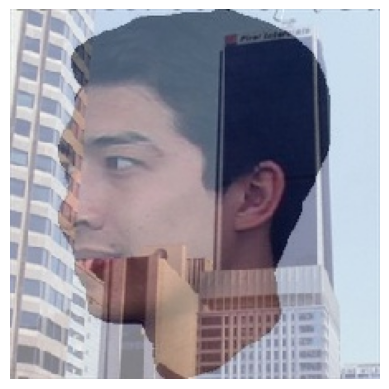

In [ ]:
# Merged images load
merge_data = [[]  for i in range(8)]
merge_data[0] = convertimgs('/content/merge/merge_data/Correct/Male',noise = False)  #75
merge_data[1] = convertimgs('/content/merge/merge_data/Correct/Female/',noise = False) #75
merge_data[2] = convertimgs('/content/merge/merge_data/Correct/Manmade/',noise = False) #75
merge_data[3] = convertimgs('/content/merge/merge_data/Correct/Natural/',noise = False) #75


merge_data[4] = convertimgs('/content/merge/merge_data/Incorrect/Male',noise = False) #75
merge_data[5] = convertimgs('/content/merge/merge_data/Incorrect/Female',noise = False) #75
merge_data[6] = convertimgs('/content/merge/merge_data/Incorrect/Manmade',noise = False) #75
merge_data[7] = convertimgs('/content/merge/merge_data/Incorrect/Natural',noise = False) #75
merge_data = np.array(merge_data)




print(merge_data.shape)

plt.imshow(merge_data[0,1])
plt.axis('off')

# Regular Images load

reg_train = [[]  for i in range(8)]
reg_train[0] = convertimgs('/content/merge/merge_reg_train/Correct/Male',noise = False)  # 75
reg_train[1] = convertimgs('/content/merge/merge_reg_train/Correct/Female',noise = False) # 75
reg_train[2] = convertimgs('/content/merge/merge_reg_train/Correct/Manmade',noise = False) # 75
reg_train[3] = convertimgs('/content/merge/merge_reg_train/Correct/Natural/',noise = False) # 75


reg_train[4] = convertimgs('/content/merge/merge_reg_train/Incorrect/Male',noise = False)  # 75
reg_train[5] = convertimgs('/content/merge/merge_reg_train/Incorrect/Female',noise = False) # 75
reg_train[6] = convertimgs('/content/merge/merge_reg_train/Incorrect/Manmade',noise = False) # 75
reg_train[7] = convertimgs('/content/merge/merge_reg_train/Incorrect/Natural/',noise = False) # 75
reg_train = np.array(reg_train)


print(reg_train.shape)



# Model
Call the base model and the top model here

### Model Architecture

In [ ]:
# Calling VGG16 without the top FC layers with weights loaded from imagenet
# vgg = VGG16(weights=None,
#               include_top=False,input_shape = [224,224,3])

# output = vgg.output
# x = Flatten()(output)
# x = Dense(4096,activation = 'relu')(x)
# x = Dense(4096,activation = 'relu')(x)
# x = Dense(2622,activation = 'softmax')(x)

# model2 = Model(inputs = vgg.input, outputs = x)
# model2.load_weights('/content/vggface_files/vggface_weights.h5')
# model2.summary()

# model = VGG16(weights=None,
#               include_top=False,input_shape = [224,224,3])

# for layer in range(13):
#   model.layers[layer].set_weights(model2.layers[layer].get_weights())

model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])




categories = ['Male','Female','Manmade','Natural']
interest = 0
print('Category of interest: ', categories[interest])
train_it = np.concatenate((reg_train[interest],reg_train[interest + 4]))

start = time.time()
features_train = model.predict(train_it)
print(f'Train Time: {time.time() - start}')

epochs = 30

ntrain = 80
train_labels = to_categorical([0] * ntrain + [1]*ntrain)
ntest = 40
test_labels = to_categorical([0] * ntest + [1]*ntest)

losses = 'binary_crossentropy'

# Initialize the top model with FC layers. These are the only ones to be trained
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:]))
top_model.add(Dense(4096, activation='relu',name = 'top_dense1'))
#top_model.add(Dense(4096, activation='relu',name = 'top_dense2'))
top_model.add(Dense(2, activation='softmax',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
es = EarlyStopping(monitor='loss', mode='min', verbose=1)


### Model Testing

Train the model on regular images, and then test separately on regular images
followed by testing separately for merged images

In [ ]:

kf = KFold(n_splits=5)
acc = np.zeros((2,4,kf.get_n_splits()))

for i, (train_index, test_index) in enumerate(kf.split(reg_train[0])):
  for imtype in range(2):
    for cat in range(0,4):
      print('Category of interest: ', categories[cat])

      input = np.concatenate((reg_train[cat],reg_train[cat + 4]))
      idx = np.random.permutation(len(input))
      input = input[idx]
      ntrain = len(reg_train[cat])
      targets = to_categorical([0] * ntrain + [1]*ntrain)
      targets = targets[idx]

      train_it = input[train_index]
      train_data = model.predict(train_it)
      train_labels = targets[train_index]

      if imtype == 0: # Regular

        test_it = input[test_index]
        test_data = model.predict(test_it)
        test_labels = targets[test_index]

        history = top_model.fit(x = train_data,  y = train_labels,
                epochs=epochs,
                batch_size=64,
                verbose = 0, callbacks = [es])

        out = top_model.evaluate(test_data, test_labels)
        acc[imtype,cat,i] = out[1]
        print(out)
      else:
      #   test_it = np.concatenate((data_test[cat],data_test[cat + 4])) # Test on merged data
      # print(train_it.shape,test_it.shape)


        howmany = np.random.permutation(int(len(input)/2))
        merge_test = np.concatenate((merge_data[cat][howmany],merge_data[cat + 4][howmany]))
        ntest = len(merge_data[cat])
        merge_targets = to_categorical([0] * ntest + [1]*ntest)

        idx = np.random.permutation(len(merge_test))
        merge_test = merge_test[idx]
        merge_targets = merge_targets[idx]

        test_it = merge_test[test_index]
        test_data = model.predict(test_it)
        test_labels = merge_targets[test_index]

        history = top_model.fit(x = train_data,  y = train_labels,
                epochs=epochs,
                batch_size=64,
                verbose = 0, callbacks = [es])

        out = top_model.evaluate(test_data, test_labels)
        acc[imtype,cat,i] = out[1]
        print(out)


### Prelim result plots
Plot the average accuracy obtained for regular vs merged images

In [ ]:
import scipy.stats as stats
def f_test(group1, group2):
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = len(group1)-1
    dun = len(group2)-1
    p_value = 1-stats.f.cdf(f, nun, dun)
    return f, p_value
p = []
cat = 0
p = stats.ttest_ind(acc[cat][0],acc[cat][1],equal_var = False, alternative = 'greater').pvalue
p

# from statsmodels.stats.multitest import fdrcorrection
# fdrcorrection(p)

0.2945365431004029

<ipython-input-15-69072fbe8e12>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Regular','Merged'],size = 10)


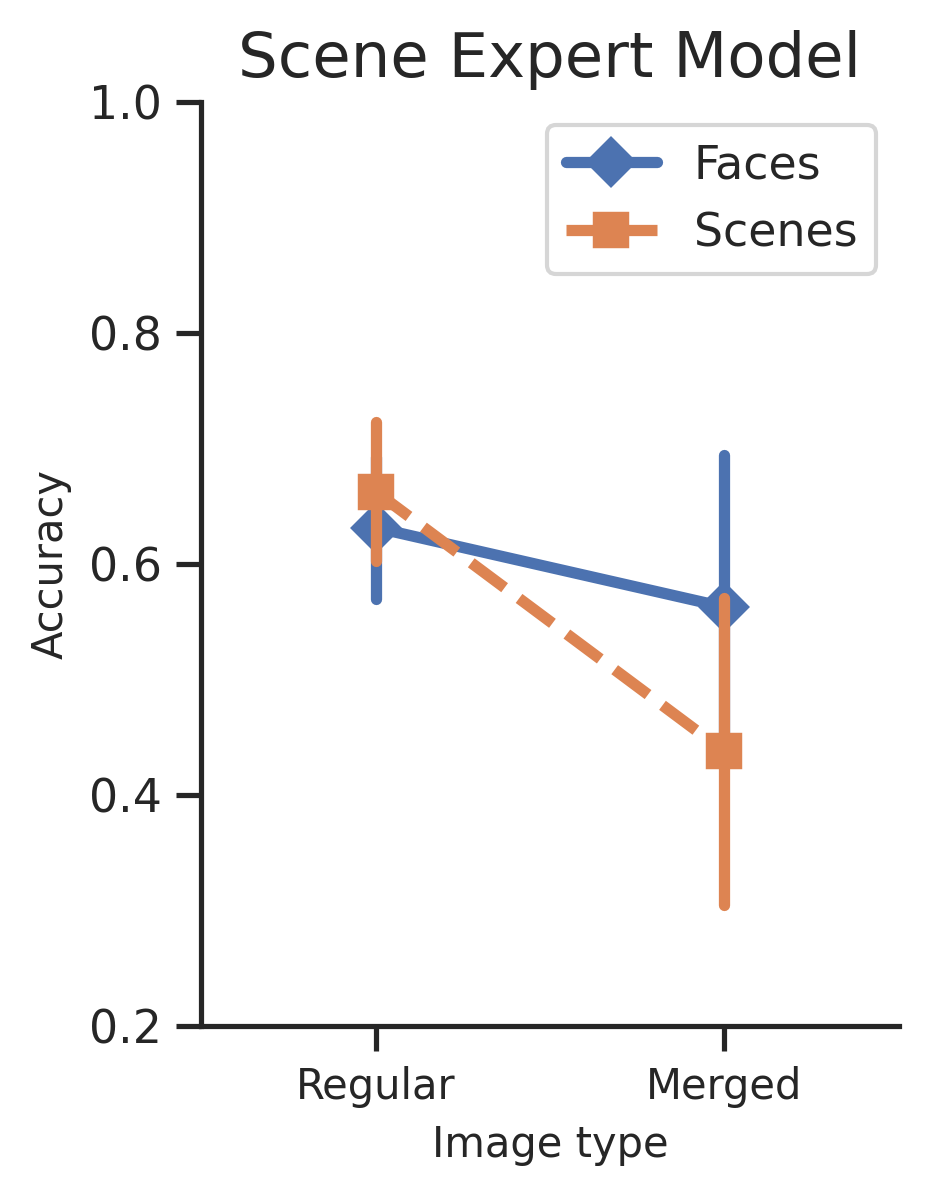

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize = (3,4))
sns.color_palette('pastel')
sns.set(font_scale=1,style="ticks")
maincats = ['Regular','Merged']

datatable = pd.DataFrame(columns = ["Faces","Scenes","Type"])
datatable2 = pd.DataFrame(columns = ["Faces","Scenes","Type"])


A = np.concatenate((acc[0][0],acc[0][1]),0)
B = np.concatenate((acc[0][2],acc[0][3]),0)
C = np.concatenate((acc[1][0],acc[1][1]),0)
D = np.concatenate((acc[1][2],acc[1][3]),0)
#plt.subplot(1,4,i+1)
datatable["Faces"] = A
datatable["Scenes"] = B
datatable["Type"] = "Regular";
datatable2["Faces"] = C
datatable2["Scenes"] = D
datatable2["Type"] = "Merged";
plottable = pd.concat([datatable,datatable2])

ax = sns.pointplot(x='Type', y='Faces', data=plottable,errorbar = 'se',
              linestyles = "-",label = 'Faces',markers = 'D')
ax = sns.pointplot(x='Type', y='Scenes', data=plottable,errorbar = 'se',
              linestyles = "--",label = 'Scenes',markers = 's')

plt.legend()

ax.set_title('Scene Expert Model',size = 15)
ax.set_ylabel('Accuracy',size = 10)
ax.set_xlabel('Image type',size = 10)
ax.set_xticklabels(['Regular','Merged'],size = 10)
ax.set_yticks(np.arange(0.2,1.1,0.2))
ax.set_ylim(0.2,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.savefig('/content/plots/imtrain_classif.png')  # saves the current figure
#plt.savefig('/content/plots/imtrain_classif.jpeg')  # saves the current figure

In [ ]:
! zip -r /content/plots.zip /content/plots

updating: content/plots/ (stored 0%)
  adding: content/plots/vggface_classif.png (deflated 12%)
  adding: content/plots/imtrain_classif.png (deflated 11%)
  adding: content/plots/imtrain_classif.jpeg (deflated 33%)
  adding: content/plots/vggface_classif.jpeg (deflated 36%)


# Tuning Value Calculation

In [ ]:
calc_tun_activ = 1

if calc_tun_activ:
  for cat in range(len(categories)):

    print('Category of interest: ', categories[cat])
    train_it = reg_train[cat]

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)


    start = time.time()
    tun_activ = tc.calc_tun(train_it,activation_model,layer_names)
    print(f'Elapsed: {time.time() - start}s')

    with open('/content/drive/MyDrive/tuning_vals/vggface_tuning_values_' + str(cat), 'wb') as fp:
      pickle.dump(tun_activ, fp)



### Load tuning activities

In [ ]:
tun_activ = []
for interest in range(len(categories)):
  with open ('/content/drive/MyDrive/tuning_vals/imgnet_tuning_values_' + str(interest), 'rb') as fp:
      tun_activ.extend(pickle.load(fp))
len(tun_activ)



320

### Calculation of tuning values for each map

In [ ]:
ncats = 4
# to fish out each category tun_activations
labels = np.array([0] * 80 + [1] * 80 + [2] * 80 + [3] * 80)
cat_tun = [[[] for j in range(len(tun_activ[0]))] for i in range(ncats)]

avg_tun_activ = tc.calc_avg(tun_activ) #average tuning activity for each map
std_tun_activ = tc.calc_std(tun_activ,avg_tun_activ) #std tuning activity for each map

for i in range(ncats):
  #Calculating average activity of each
  #feature map in response to images of respective category,
  #with the mean activity under all image categories subtracted from it
  idx = list(np.where(labels == i))
  cat_tun[i] = tc.calc_avg([tun_activ[i] for i in idx[0]])

# Vector of tuning values for each obj cataegory
fc = [[[0 for item in subl] for subl in cat_tun[0]] for i in range(ncats)]
#fc has length of ncats x nlayers x no of maps in each layer
for cat in range(ncats):
  for layer in range(len(cat_tun[cat])):
    for map in range(len(cat_tun[cat][layer])):
      if std_tun_activ[layer][map] == 0:
        continue
      fc[cat][layer][map] = (cat_tun[cat][layer][map] -
                                avg_tun_activ[layer][map])/std_tun_activ[layer][map]


## Example Tuning Curves

In [ ]:
#@title Examples
from matplotlib.lines import Line2D
color1 = '#e0a341'      #ed3232, 944848 for faces
color2 = '#4c65c2'      #edb647, 6b4c0d for scenes
colors = iter(['#944848', '#ed3232', '#edb647','#6b4c0d'])
idx = [[-1 for item in subl] for subl in fc[0]]
for layer in range(13):
  for map in range(len(fc[0][layer])):
    max = 0
    for cat in range(ncats):
      if fc[cat][layer][map] > max:
        max = fc[cat][layer][map]
        idx[layer][map] = cat
counter = 1
plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize = (20,6),dpi = 300)
for layer in [2,5,7,10,12]:
  colors = iter(['#944848', '#ed3232', '#edb647','#6b4c0d'])
  ls = iter(['-','--','-.',':'])
  markers = iter(['o','v','^','s'])
  ax = plt.subplot(1,5,counter)

  a = np.zeros((4,4))
  for cat in range(ncats):
    where = [i for i,x in enumerate(idx[layer]) if x == cat]
    whereis = np.random.randint(len(where))
    a[0,cat] = fc[0][layer][where[whereis]]
    a[1,cat] = fc[1][layer][where[whereis]]
    a[2,cat] = fc[2][layer][where[whereis]]
    a[3,cat] = fc[3][layer][where[whereis]]

    plt.plot(a[:,cat],linewidth = 2,c = next(colors),linestyle = next(ls),
             marker = next(markers),alpha = 1,
             label = categories[cat])
  ax.text(2,np.amin(a),'Unit '+str(whereis),c = '#7f7f7f')




  ax.set_xticks([0,1,2,3])
  ax.set_xticklabels(['Male','Female','Manmade','Natural'])


  if counter != 1:
    ax.set_yticks([])
    ax.spines[['right', 'top','left']].set_visible(False)
  else:
    ax.set_yticks([])
    #ax.set_yticks(np.arange(-15,16,15))
    #ax.set_yticklabels(['-15','0','15'],fontsize = 15)
    ax.spines[['right', 'top']].set_visible(False)

  ax.set_title('Layer ' + str(layer),fontsize = 15)
  ax.spines[['left','bottom']].set_linewidth(3)
  ax.spines[['bottom','left']].set_color('#bebebe')
  ax.tick_params(axis='both', colors='#7f7f7f')
  counter = counter + 1

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[0:4], labels[0:4],loc = 8,ncol = 4,fontsize = 15,bbox_to_anchor=(0.5, -0.1))

plt.savefig('example_tc.png',dpi = 300)  # saves the current figure
plt.savefig('example_tc.jpeg',dpi = 300)  # saves the current figure

# Tuning quality for face and scene images
Modified on March 2024 to find the range of tuning for each subcategory within a category

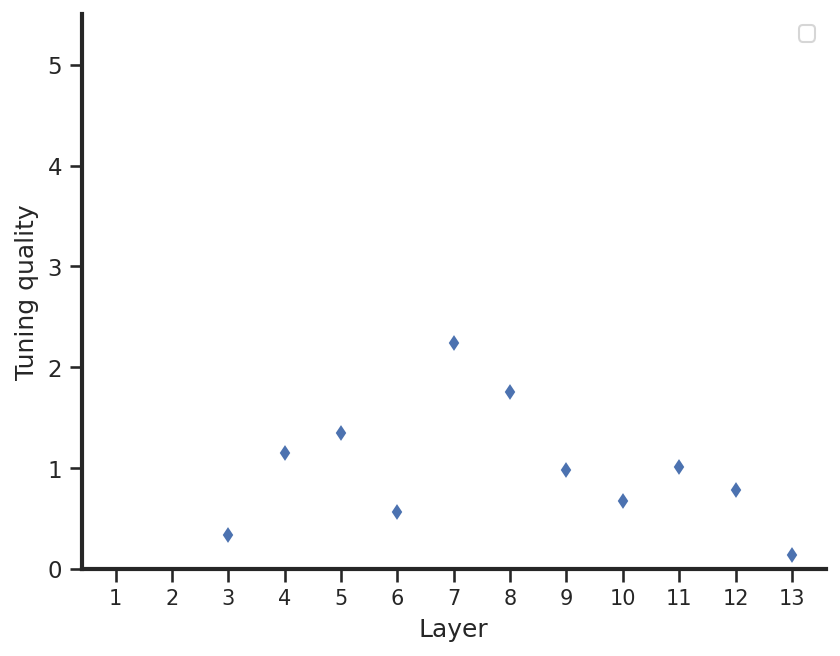

In [ ]:
import importlib
importlib.reload(tc)
tun_q_1 = tc.calc_tun_quality(fc)


plt.rcParams['figure.dpi'] = 150
import scipy.stats as stats

m = np.empty([13])
n = np.empty([13])
merr = np.empty([13])
nerr = np.empty([13])

r1 = np.arange(13)
barW = 0.4
r2 = [x + 0 for x in r1]

for l in range(13):
  m[l] = np.mean(tun_q_1[2][l])
  merr[l] = stats.sem(tun_q_1[2][l])
  n[l] = np.mean(tun_q_1[3][l])
  nerr[l] = stats.sem(tun_q_1[3][l])
maindiff = m-n
ax = plt.subplot(111)


#ax.errorbar(r1,m,label='Male Faces',yerr = merr,capsize=2,color = '#944848',fmt='d',markersize=4)#ed3232, 944848
ax.errorbar(r1,maindiff,capsize=2,fmt='d',markersize=4)#ed3232, 944848
#ax.errorbar(r2,n,label='Female Faces',yerr = nerr,capsize=2,color = '#ed3232',fmt='o',markersize=4)#edb647,6b4c0d
plt.xticks([r  for r in range(13)], np.arange(1,14),fontsize = 10)
plt.legend(fontsize = 10)
plt.ylabel('Tuning quality')
plt.xlabel('Layer')
ax.set_ylim(0,5.5)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
# plt.savefig('imtrain_tun_q_scenes.png')  # saves the current figure
# plt.savefig('imtrain_tun_q_scenes.jpeg')  # saves the current figure

In [ ]:
#@title Neuron counts
width = 0.4
plt.rcParams['figure.dpi'] = 300

idx = [[-1 for item in subl] for subl in fc[0]]
for layer in range(13):
  for map in range(len(fc[0][layer])):
    max = 0
    for cat in range(ncats):
      if fc[cat][layer][map] > max:
        max = fc[cat][layer][map]
        idx[layer][map] = cat

c_face = np.zeros(13)
c_scene = np.zeros(13)


for layer in range(13):
  for ele in idx[layer]:
    if ele == 0 or ele == 1:
      c_face[layer] += 1
    elif ele == 2 or ele ==3:
      c_scene[layer] += 1
c_scene[2] = 19
c_scene[0] = 25
total_units = np.array([64,64,128,128,256,256,256,512,512,512,512,512,512])
c_face_ratio = np.divide(c_face,total_units)
c_scene_ratio = np.divide(c_scene,total_units)



fig, ax = plt.subplots(figsize = (10,8))
rects1 = ax.bar(np.arange(13), c_face_ratio, label='Faces',color = '#D65353')

rects2 = ax.bar(np.arange(13), c_scene_ratio, label='Scenes',color = '#F7C45F',bottom = c_face_ratio)

counter = 0
data = c_face
for bar in ax.patches:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + bar.get_y() - 0.1,
      round(data[counter]),
      ha='center',
      color='w',
      weight='regular',
      size=12
  )
  counter = counter + 1
  if counter > 12:
    counter = 0
    data = c_scene


ax.axhline(y = 0.5,color = [0.3,0.3,0.3],linestyle = '--')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(np.arange(13))
ax.legend(loc = 7,bbox_to_anchor=(1.1, 1.1))

plt.ylim(0,1.05)
plt.yticks([0,0.2,0.4,0.6,0.8,1],['0','0.2','0.4','0.6','0.8','1'],size = 20)
plt.xticks(np.arange(13),np.arange(1,14),size = 20)
plt.xlabel('Layer',size = 15)
plt.ylabel('Proportion of Maps',size = 15)
plt.title('Number of selective neurons, category wise', size = 15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.savefig('facetrain_count.png')  # saves the current figure
plt.savefig('facetrain_count.jpeg')  # saves the current figure

## SVM


In [ ]:
#@title SVM on neurons
from vgg16obj.tools.model_calcs import run_SVM

idx = [[-1 for item in subl] for subl in fc[0]]
for layer in range(13):
  for map in range(len(fc[0][layer])):
    max = 0
    for cat in range(ncats):
      if fc[cat][layer][map] > max:
        max = fc[cat][layer][map]
        idx[layer][map] = cat

acc_faces_male = np.zeros(13)
acc_faces_female = np.zeros(13)
acc_scene_manmade = np.zeros(13)
acc_scene_natural = np.zeros(13)

for li in range(13):

  c_face_male = []
  c_face_female = []
  c_face_manmade = []
  c_face_natural = []
  c_scene_male = []
  c_scene_female = []
  c_scene_manmade = []
  c_scene_natural = []

  index = [i for i, e in enumerate(idx[li]) if e == 0 or e == 1]
  for imgs in range(len(neuron_act[0])):

    c_face_male.append(neuron_act[0][imgs][li][:,:,index])
    c_face_female.append(neuron_act[1][imgs][li][:,:,index])
    c_face_manmade.append(neuron_act[2][imgs][li][:,:,index])
    c_face_natural.append(neuron_act[3][imgs][li][:,:,index])


  index = [i for i, e in enumerate(idx[li]) if e == 2 or e == 3]
  for imgs in range(len(neuron_act[0])):

    c_scene_manmade.append(neuron_act[2][imgs][li][:,:,index])
    c_scene_natural.append(neuron_act[3][imgs][li][:,:,index])
    c_scene_male.append(neuron_act[0][imgs][li][:,:,index])
    c_scene_female.append(neuron_act[1][imgs][li][:,:,index])


  c_face_male = np.mean(np.array(c_face_male),(1,2))
  c_face_female = np.mean(np.array(c_face_female),(1,2))
  c_face_manmade = np.mean(np.array(c_face_manmade),(1,2))
  c_face_natural = np.mean(np.array(c_face_natural),(1,2))

  c_scene_manmade = np.mean(np.array(c_scene_manmade),(1,2))
  c_scene_natural = np.mean(np.array(c_scene_natural),(1,2))
  c_scene_male = np.mean(np.array(c_scene_male),(1,2))
  c_scene_female = np.mean(np.array(c_scene_female),(1,2))

  idxs = np.random.choice(80,27,replace = False)
  x = np.concatenate((c_face_female[idxs,:],c_face_manmade[idxs,:],c_face_natural[idxs,:]))
  acc_faces_male[li] = run_SVM(c_face_male,x)

  x = np.concatenate((c_face_male[idxs,:],c_face_manmade[idxs,:],c_face_natural[idxs,:]))
  acc_faces_female[li] = run_SVM(c_face_female,x)

  x = np.concatenate((c_scene_female[idxs,:],c_scene_natural[idxs,:],c_scene_male[idxs,:]))
  acc_scene_manmade[li] = run_SVM(c_scene_manmade,x)

  x = np.concatenate((c_scene_female[idxs,:],c_scene_manmade[idxs,:],c_scene_male[idxs,:]))
  acc_scene_natural[li] = run_SVM(c_scene_natural,x)



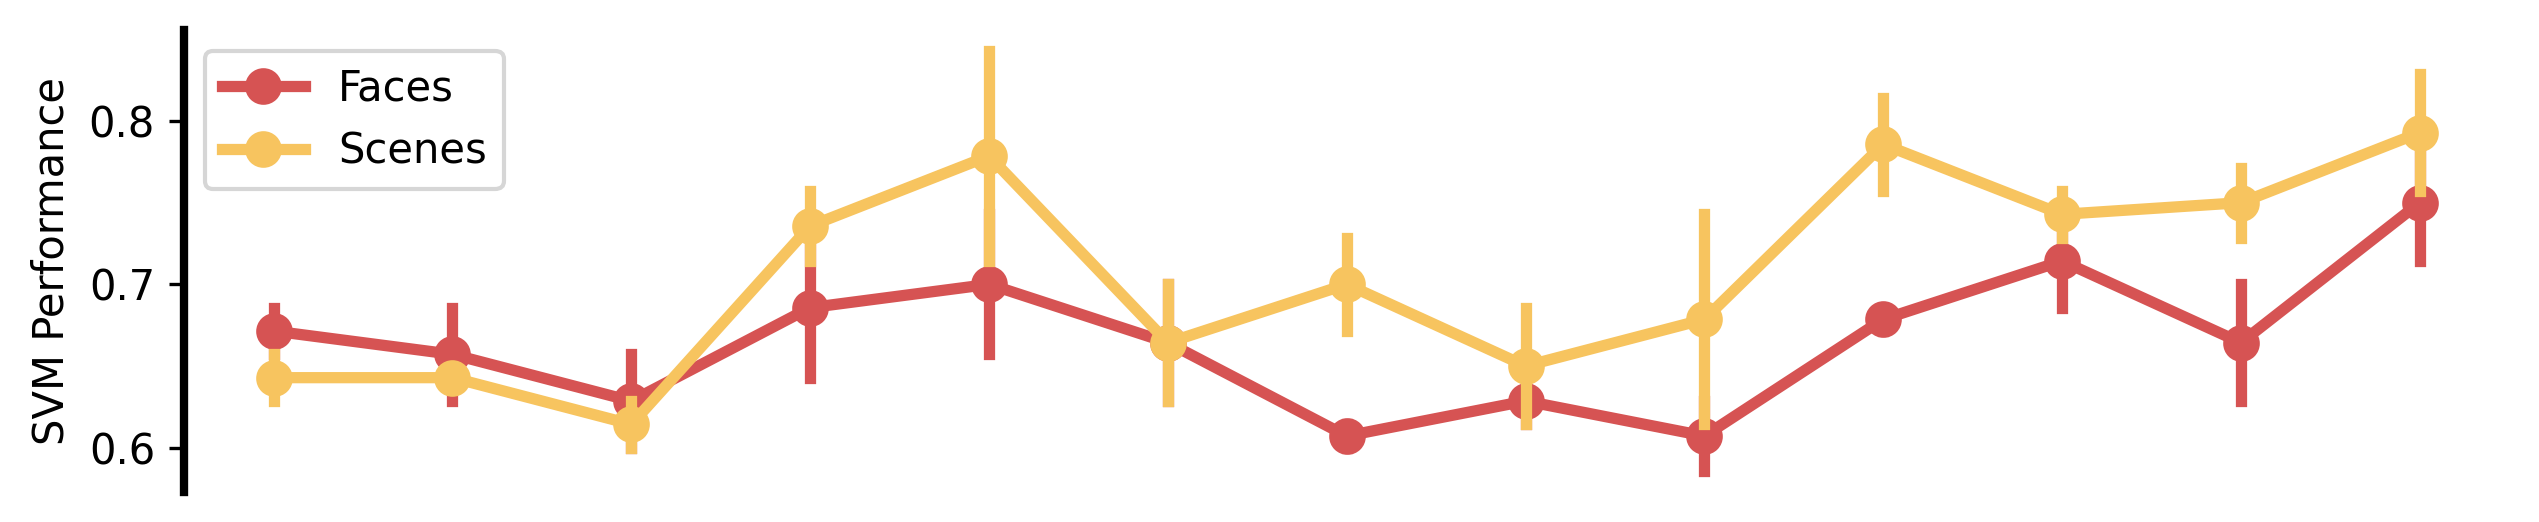

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(10, 2))
ax = plt.subplot(111)
sns.pointplot(np.vstack((acc_faces_male.T,acc_faces_female.T)),label = 'Faces',color = "#D65353")
sns.pointplot(np.vstack((acc_scene_manmade.T,acc_scene_natural.T)),label = 'Scenes',color = "#F7C45F")

plt.legend()

#plt.xticks([r  for r in range(13)], np.arange(1,14),fontsize = 10)
plt.xticks([])
plt.legend(fontsize = 10)
plt.ylabel('SVM Performance')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_linewidth(2)
#plt.savefig('/content/plots/vggface_SVM_perf_fc_.png')  # saves the current figure
#plt.savefig('/content/plots/vggface_SVM_perf_fc_.jpeg')  # saves the current figure
# with open('vggface_SVM_perf_fc.npy', 'wb') as f:
#     np.save(f, acc_faces_male)
#     np.save(f, acc_faces_female)
#     np.save(f, acc_scene_manmade)
#     np.save(f, acc_scene_natural)


# Attention

### Att
(This is optional. The same code is written in vgg16obj/tools/model_calcs.py called separately in the next driver chunk

In [ ]:
# vgg = VGG16(weights=None,
#               include_top=False,input_shape = [224,224,3])

# output = vgg.output
# x = Flatten()(output)
# x = Dense(4096,activation = 'relu')(x)
# x = Dense(4096,activation = 'relu')(x)
# x = Dense(2622,activation = 'softmax')(x)

# model2 = Model(inputs = vgg.input, outputs = x)
# model2.load_weights('/content/vggface_files/vggface_weights.h5')

# model = VGG16(weights=None,
#               include_top=False,input_shape = [224,224,3])

# for layer in range(13):
#   model.layers[layer].set_weights(model2.layers[layer].get_weights())

model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])


In [ ]:
#@title Multiplicative and bidirectionality corrected

import gc
from multiprocessing import Process, Queue
from vgg16obj.tools.model_calcs import avg_accuracy
layeridx = 0
np.save('layeridx',layeridx)
ncats = 4
grand_acc = [[] for i in range(ncats)]
for atstrng in np.arange(2,6,1): #Calling for different attn strengths
  grand_acc = [[] for i in range(ncats)]
  for cat in range(ncats): # Iterating over 4 categories
    print('Category of interest: ', categories[cat])
    input = np.concatenate((reg_train[cat],reg_train[cat + 4]))
    idx = np.random.permutation(len(input))
    input = input[idx]

    targets = to_categorical([0] * len(reg_train[cat]) + [1]*len(reg_train[cat]))
    targets = targets[idx]

    howmany = np.random.permutation(int(len(input)/2))
    input_Test = np.concatenate((merge_data[cat][howmany],merge_data[cat + 4][howmany]))


    merge_targets = to_categorical([0] * len(howmany) + [1]*len(howmany ))

    top_model = Sequential()
    top_model.add(Flatten(input_shape=features_train.shape[1:]))
    top_model.add(Dense(4096, activation='relu',name = 'top_dense1'))
    top_model.add(Dense(4096, activation='relu',name = 'top_dense2'))
    top_model.add(Dense(2, activation='sigmoid',name = 'predictions'))
    top_model.compile(optimizer= Adam(lr=1e-3),
                loss='binary_crossentropy',
                metrics=['accuracy'])

    #queue = Queue()  # Here
    p1 = Process(target=avg_accuracy(input,
                              targets,
                              input_Test,
                              merge_targets,
                              fc,
                              model,top_model,
                              '/content/layeridx.npy',
                              cat,
                              atstrng,
                              bidir = True,
                              atype = 1), args=('not used'))
    p1.start()
    p1.join()

    grand_acc[cat]  = np.load('temp.npy')

    del top_model
    gc.collect()

  grand_acc = np.array(grand_acc)
  grand_acc.reshape([13,4,5])
  np.save('/content/drive/MyDrive/objfiles/vggface_tun_accuracy_multi' + str(atstrng),grand_acc)

### Category wise plot
This code generates the plot for performance increase as a function of category and attention applied at each layer separately.

In [ ]:
acc = [0.38,0.38,0.45,0.45 ]

gacc = np.load('/content/drive/MyDrive/objfiles/tun_accuracy_multi1.npy')
categories = ["Male","Female","Manmade","Natural"]
y = np.expand_dims(gacc,0)
temp = np.load('/content/drive/MyDrive/objfiles/tun_accuracy_multi0.5.npy')
y = np.concatenate((y,temp.reshape(1,4,13,5)))

for i in range(2,7):
  temp = np.load('/content/drive/MyDrive/objfiles/tun_accuracy_multi' + str(i) + '.npy')
  y = np.concatenate((y,temp.reshape(1,4,13,5)))

y = np.amax(y,axis=0)


plt_data = np.zeros((4,13,5))
for i in range(13):
  for j in range(4):
    for k in range(5):
      plt_data[j,i,k] = y[j,i,k] - acc[j]


fig, axes = plt.subplots(2, 2, sharex=True, figsize=(10,5))
sns.set(style="white",rc={"lines.linewidth": 1})
sns.set(font_scale=1,style='ticks')
layer = 0
plt.rcParams['figure.dpi'] = 150
axes = axes.flatten()

for cats in range(4):
  sns.pointplot(plt_data[cats].T,ax = axes[cats])
  axes[cats].set_ylim(0,0.5)
  axes[cats].set_title(categories[cats])
np.save('merge_set.npy',plt_data)

# Why is attention doing this?

In [172]:
# prompt: Merge the git contents of vgg16obj to a github repository at https://github.com/soukhind2/vgg16obj at branch tuning_calc
!git config --global user.email "soukhind2@gmail.com"
!git config --global user.name "soukhind2"
#!git clone https://github.com/soukhind2/vgg16obj.git
%cd /content/vgg16objcopy
!git checkout tuning_calc
!git add -A
!git commit -m "Merge vgg16obj to tuning_calc branch"
!git push origin tuning_calc


/content/vgg16objcopy
Already on 'tuning_calc'
Your branch is ahead of 'origin/tuning_calc' by 1 commit.
  (use "git push" to publish your local commits)
On branch tuning_calc
Your branch is ahead of 'origin/tuning_calc' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
#@title Why is attention doing this?
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

def calc_tuningprops(categories,model,data):
  calc_tun_activ = 1

  if calc_tun_activ:
    for cat in range(len(categories)):

      print('Category of interest: ', categories[cat])
      train_it = data[cat]

      layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
      layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
      activation_model = Model(inputs=model.input, outputs=layer_outputs)

      with suppress_stdout():
        start = time.time()
        tun_activ = tc.calc_tun(train_it,activation_model,layer_names)
        print(f'Elapsed: {time.time() - start}s')

      with open('/content/temp' + str(cat), 'wb') as fp:
        pickle.dump(tun_activ, fp)

  tun_activ = []
  for interest in range(len(categories)):
    with open ('/content/temp' + str(interest), 'rb') as fp:
        tun_activ.extend(pickle.load(fp))
  len(tun_activ)


  ncats = len(categories)
  # to fish out each category tun_activations
  ntrain = len(data[0])
  labels = np.array([0] * ntrain + [1] * ntrain + [2] * ntrain + [3] * ntrain)
  cat_tun = [[[] for j in range(len(tun_activ[0]))] for i in range(ncats)]

  avg_tun_activ = tc.calc_avg(tun_activ) #average tuning activity for each map
  std_tun_activ = tc.calc_std(tun_activ,avg_tun_activ) #std tuning activity for each map

  for i in range(ncats):
    #Calculating average activity of each
    #feature map in response to images of respective category,
    #with the mean activity under all image categories subtracted from it
    idx = list(np.where(labels == i))
    cat_tun[i] = tc.calc_avg([tun_activ[i] for i in idx[0]])

  # Vector of tuning values for each obj cataegory
  fc = [[[0 for item in subl] for subl in cat_tun[0]] for i in range(ncats)]
  #fc has length of ncats x nlayers x no of maps in each layer
  for cat in range(ncats):
    for layer in range(len(cat_tun[cat])):
      for map in range(len(cat_tun[cat][layer])):
        if std_tun_activ[layer][map] == 0:
          continue
        fc[cat][layer][map] = (cat_tun[cat][layer][map] -
                                  avg_tun_activ[layer][map])/std_tun_activ[layer][map]

  tun_q = tc.calc_tun_quality(fc)
  return tun_q

def attn_properties(data,
                 modifier,
                 model,idxpath,
                 category,
                 atstrng,
                 bidir = True,
                 atype = 1):


    n_layers = 13
    categories = ["Males","Females","Manmades","Naturals"]
    for li in range(n_layers):
      print('Layer of interest: ', li)
      layermask = np.zeros(n_layers)
      layermask[li] = 1
      tensor_attnmap = gen_attnmap(modifier,layermask*atstrng,category,bidir,atype)

      @keras.utils.register_keras_serializable(package="my_package", name="attnrelu")
      def attnrelu(x,map = tensor_attnmap,atype = atype):
          layeridx = np.load(idxpath)
          if layeridx == 13:
              layeridx = 0
          if atype == 1:
            x = nn.relu(x)
            activations = math.multiply(x,map[layeridx])
          if atype == 2:
            activations = math.add(x,map[layeridx])
            activations = nn.relu(activations)
          layeridx += 1
          np.save(idxpath,layeridx)
          return activations

      get_custom_objects().update({'attnrelu': Activation(attnrelu)})
      with custom_object_scope({'attnrelu': attnrelu}):

        for layer in model.layers:
            if(hasattr(layer,'activation')):
                layer.activation = attnrelu

        del tensor_attnmap
        #utils.apply_modifications(model)

        model_tq = calc_tuningprops(categories,model,data)
        with open('/content/drive/MyDrive/objfiles/attnbasedtq/imnetattn_tq_layer_'+
                str(li) + '_cat_'+str(cat), 'wb') as fp:
          pickle.dump(model_tq, fp)


    del model

In [ ]:
import gc
from multiprocessing import Process, Queue
layeridx = 0
np.save('layeridx',layeridx)
ncats = 4

for atstrng in np.arange(1,2,1): #Calling for different attn strengths

  for cat in [0,1,2,3]: # Iterating over 4 categories
    print('Category of interest: ', categories[cat])

    attn_properties(reg_train,
                              fc,
                              model,
                              '/content/layeridx.npy',
                              cat,
                              atstrng,
                              bidir = True,
                              atype = 1)

    gc.collect()

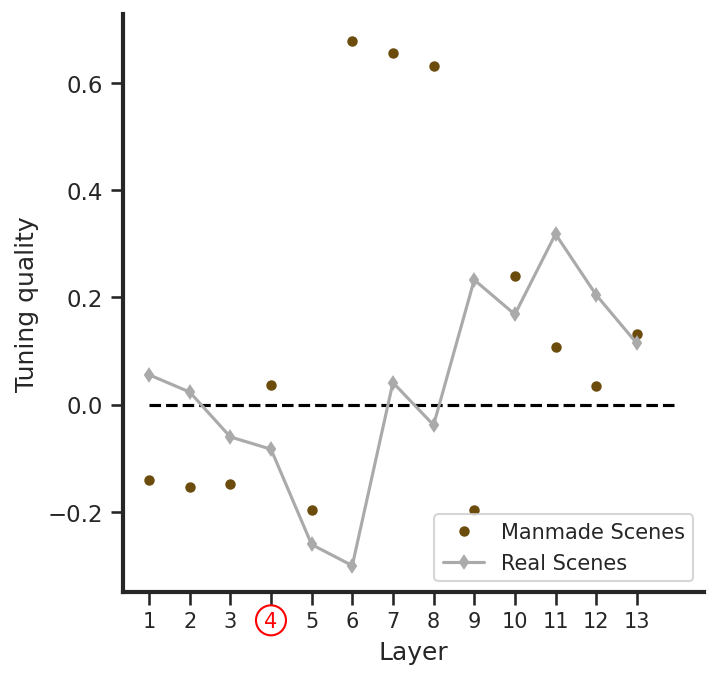

In [ ]:
tq = []
li = 3
cat = 1

with open ('/content/drive/MyDrive/objfiles/attnbasedtq/vggfaceattn_tq_layer_'+
              str(li) + '_cat_'+str(cat), 'rb') as fp:
  tq.extend(pickle.load(fp))


plt.rcParams['figure.dpi'] = 150

m = np.empty([13])
n = np.empty([13])
diff = np.empty([13])
merr = np.empty([13])
nerr = np.empty([13])

r1 = np.arange(13)
barW = 0.4
r2 = [x + 0 for x in r1]

for l in range(13):
  m[l] = np.mean(tq[2][l])
  merr[l] = stats.sem(tq[2][l])
  n[l] = np.mean(tq[3][l])
  nerr[l] = stats.sem(tq[3][l])
  diff[l] = m[l] - n[l]

fig,ax = plt.subplots(figsize=(5,5))


ax.errorbar(r1,diff,label='Manmade Scenes',capsize=2,color = '#6b4c0d',fmt='o',markersize=4)#ed3232, 944848
ax.errorbar(r1,maindiff,label='Real Scenes',capsize=2,color = '#aaaaaa',fmt='d',markersize=4,linestyle = '-')#ed3232, 944848
ax.hlines(0,0,13,color = 'black',linestyle = '--')
ax.get_xticklabels()[li].set_color("red")

#ax.errorbar(r2,n,label='Natural Scenes',yerr = nerr,capsize=2,color = '#edb647',fmt='o',markersize=4)#edb647,6b4c0d
plt.xticks([r  for r in range(13)], np.arange(1,14),fontsize = 10)
plt.legend(fontsize = 10)
plt.ylabel('Tuning quality')
plt.xlabel('Layer')

from matplotlib.patches import Ellipse

#ax.set_ylim(-0.06,0.06)
#ax.set_ylim(-0.5,0.5)
width = GraphDist(30, ax, True)
height = GraphDist(30, ax, False)
ax.add_artist(Ellipse((li, min(diff)-0.205),
                      width, height, facecolor="None",
                      edgecolor="red",clip_on = False))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
# plt.savefig('imtrain_tun_q_scenes.png')  # saves the current figure
# plt.savefig('imtrain_tun_q_scenes.jpeg')  # saves the current figure

In [ ]:
class GraphDist() :
    def __init__(self, size, ax, x=True) :
        self.size = size
        self.ax = ax
        self.x = x

    @property
    def dist_real(self) :
        x0, y0 = self.ax.transAxes.transform((0, 0)) # lower left in pixels
        x1, y1 = self.ax.transAxes.transform((1, 1)) # upper right in pixes
        value = x1 - x0 if self.x else y1 - y0
        return value

    @property
    def dist_abs(self) :
        bounds = self.ax.get_xlim() if self.x else self.ax.get_ylim()
        return bounds[0] - bounds[1]

    @property
    def value(self) :
        return (self.size / self.dist_real) * self.dist_abs

    def __mul__(self, obj) :
        return self.value * obj